# Feature Engineering to Improve Performance

This notebook should be using an `ml.t3.medium` instance (2 vCPU + 4 GiB)

## Download the Kaggle Dataset

### Install Packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle 

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1
  Using cached setuptools-76.0.0-py3-none-any.whl.metadata (6.7 kB)
Using cached setuptools-76.0.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.8.0
    Uninstalling setuptools-75.8.0:
      Successfully uninstalled setuptools-75.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dash 2.18.1 requires dash-core-components==2.0.0, which is not installed.
dash 2.18.1 requires dash-html-components==2.0.0, which is not installed.
dash 2.18.1 requires dash-table==5.0.0, which is not installed.
dash 2.18.1 requires Flask<3.1,>=1.0.4, but you have flask 3.1.

### Install Packages

In [4]:
import os
from dotenv import load_dotenv
import shutil
import json
import pandas as pd
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns

### Setup Kaggle API Key

In [9]:
# Load credentials from .env 
load_dotenv()

# Retrieve Kaggle credentials
kaggle_username = os.getenv("KAGGLE_USERNAME")
kaggle_key = os.getenv("KAGGLE_KEY")

# Ensure the ~/.kaggle directory exists
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Save API token to kaggle.json
kaggle_config_path = os.path.join(kaggle_dir, "kaggle.json")

with open(kaggle_config_path, "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

# Set correct file permissions
os.chmod(kaggle_config_path, 0o600)

print(" Kaggle API credentials stored securely at:", kaggle_config_path)

 Kaggle API credentials stored securely at: /home/sagemaker-user/.kaggle/kaggle.json


In [17]:
os.environ["KAGGLE_CONFIG_DIR"] = "/home/ec2-user/.kaggle"

In [18]:
os.chmod("/home/ec2-user/.kaggle/kaggle.json", 0o600)

In [8]:
# download the dataset
!kaggle competitions download -c bike-sharing-demand
!unzip -o bike-sharing-demand.zip -d data/

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


### Load and Preprocess data

In [69]:
# drop the columns previously dropped in baseline model
train_df = pd.read_csv("data/train.csv")
train_df.drop(columns=['casual','registered', 'atemp'], inplace=True)
train_df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1


In [70]:
# Preview the test dataset
test_df = pd.read_csv("data/test.csv")
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [71]:
# Preview the submission dataset
submission_df = pd.read_csv("data/sampleSubmission.csv")
submission_df.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Add New Features

### We will create new features from datetime
- this will be `hour`, `month` and `is_rush_hour`

In [72]:
# create hour and month features
train_df["hour"] = pd.to_datetime(train_df["datetime"]).dt.hour
train_df["month"] = pd.to_datetime(train_df["datetime"]).dt.month

# Create rush hour feature and check it is weekday
train_df["is_rush_hour"] = ((train_df["hour"].isin([7, 8, 9, 16, 17, 18])) & (train_df["workingday"] == 1)).astype(int)

In [73]:
# view these features
train_df.head()

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,hour,month,is_rush_hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,81,0.0,16,0,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,80,0.0,40,1,1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,80,0.0,32,2,1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,75,0.0,13,3,1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,75,0.0,1,4,1,0


## Check correlation of new features to check for multicollinearity

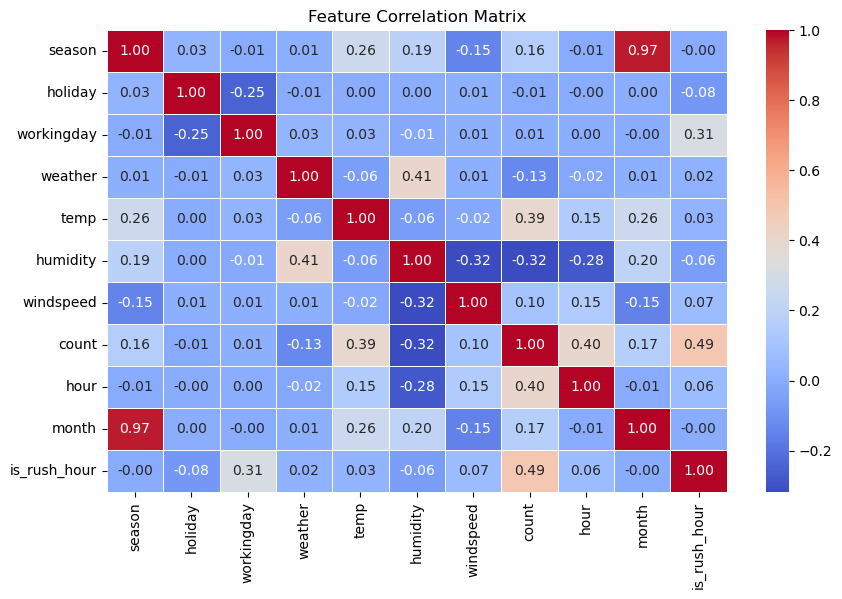

In [74]:
# Extract Numeric Features only
numeric_features = train_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

#### month and season are very strongly correlated as they are derived from each other
- season will be removed, it is adding redundant information 

In [75]:
train_df.drop(columns=['season'], inplace=True)

In [76]:
# Apply features to test df
test_df["hour"] = pd.to_datetime(test_df["datetime"]).dt.hour
test_df["month"] = pd.to_datetime(test_df["datetime"]).dt.month

# Create rush hour feature and check it is weekday
test_df["is_rush_hour"] = ((test_df["hour"].isin([7, 8, 9, 16, 17, 18])) & (test_df["workingday"] == 1)).astype(int)

## Now we will train an AutoGluon Model with these datetime features

In [77]:
predictor_new_datetime_features = TabularPredictor(label="count", 
                             eval_metric='rmse').fit(
    train_data=train_df,
    time_limit=600,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250317_204342"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Feb 11 11:40:46 UTC 2025
CPU Count:          2
Memory Avail:       1.22 GB / 3.76 GB (32.5%)
Disk Space Avail:   8589934583.59 GB / 8589934592.00 GB (100.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit

### Explore the results

In [78]:
%%capture
# Get the fit summary (without extra text)
new_datetime_features_summary = predictor_new_datetime_features.fit_summary()

In [79]:
# Extract and print only the top 5 models with key columns
print(new_datetime_features_summary["leaderboard"][["model", "score_val", "fit_time", "pred_time_val"]].head(5))

                    model  score_val    fit_time  pred_time_val
0     WeightedEnsemble_L3 -30.570485  405.330824      25.945760
1         LightGBM_BAG_L2 -30.825377  324.003354      24.151892
2       LightGBMXT_BAG_L2 -31.264310  324.597635      24.931069
3         CatBoost_BAG_L2 -31.631943  327.054180      23.983695
4  RandomForestMSE_BAG_L2 -32.043729  322.738993      24.156495


Text(0.5, 0.98, 'Leaderboard of Best Performing Models with Additional Features ')

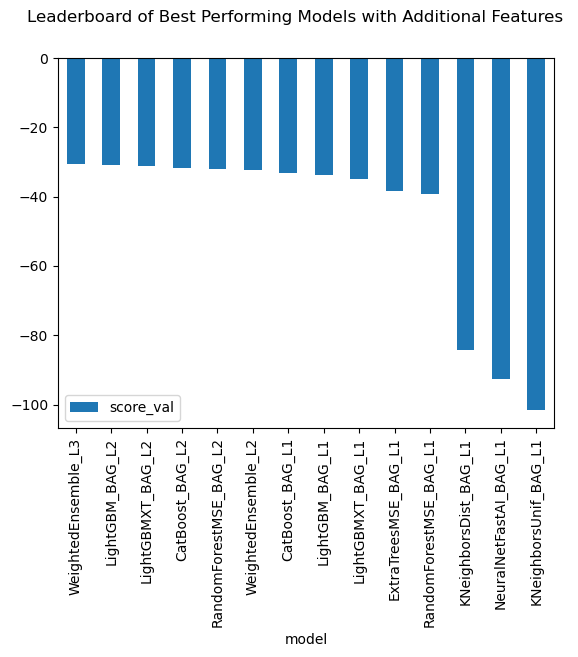

In [80]:
# Graphically view the best models
predictor_new_datetime_features.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')
plt.suptitle("Leaderboard of Best Performing Models with Additional Features ")

### Create Predictions

In [81]:
new_datetime_features_predictions = predictor_new_datetime_features.predict(test_df)
new_datetime_features_predictions.head()

0    14.718073
1     9.159974
2     8.253212
3     7.425363
4     6.444853
Name: count, dtype: float32

### Submit Predictions to Kaggle

In [82]:
# Describe the predictions data
new_datetime_features_predictions.describe()

count    6493.000000
mean      164.936646
std       143.302063
min         2.013918
25%        51.327866
50%       131.410522
75%       236.767532
max       796.181519
Name: count, dtype: float64

In [83]:
# replace any negative values with '0'
new_datetime_features_predictions = new_datetime_features_predictions.clip(lower=0)

# Check no negative values exist
(new_datetime_features_predictions<0).sum()

0

In [84]:
# Initialise submissions df from submissions example
submission_new_datetime_features_df = submission_df

# populate count column with predictions
submission_new_datetime_features_df["count"] = new_datetime_features_predictions

# Convert to csv
submission_new_datetime_features_df.to_csv("new_datetime_features_submission.csv", index=False)

In [85]:
submission_new_datetime_features_df.head()

,datetime,count
0,2011-01-20 00:00:00,14.718073
1,2011-01-20 01:00:00,9.159974
2,2011-01-20 02:00:00,8.253212
3,2011-01-20 03:00:00,7.425363
4,2011-01-20 04:00:00,6.444853


In [86]:
!kaggle competitions submit -c bike-sharing-demand -f new_datetime_features_submission.csv -m "New Datetime Features Submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 718kB/s]
Successfully submitted to Bike Sharing Demand

In [87]:
# View the Score of Baseline Submission
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                              date                        description                        status                     publicScore  privateScore  
------------------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
new_datetime_features_submission.csv  2025-03-17 21:01:17.063000  New Datetime Features Submission   SubmissionStatus.COMPLETE  0.61670      0.61670       
new_datetime_features_submission.csv  2025-03-17 20:26:50.437000  New Datetime Features Submission   SubmissionStatus.COMPLETE  0.61735      0.61735       
new_features_submission.csv           2025-03-17 19:56:51.243000  New Features Submission            SubmissionStatus.COMPLETE  0.63039      0.63039       
baseline_submission.csv               2025-03-17 17:37:12.007000  Baseline Submission                SubmissionStatus.COMPLETE  1.79680      1.79680       


### Model Summary After Creating New Datetime Features
#### The best model was the **WeightedEnsemble_L3** with an RMSE score of **30.570485** and a Kaggle score of **0.61670**.
- Note: the model was separately trained with the redundant `season` feature as well by not dropping it and the result was RMSE score of **30.581441** and a Kaggle score of **0.61735**.
- This was purely as an experiment to demonstrate how the feature was redundant, adding no value and in fact deceasing the performance slightly.
---

## Create Additional Interaction Feature
- we will now create  additional interaction features by multiplying two moderately correlated features
- If they are too strongly correlated the additional feature will be redundant
- We Will identify these features by creating a correlation matrix
- We Will then retrain the Autogluon model and analyse the impact

### Create Correlation Matrix

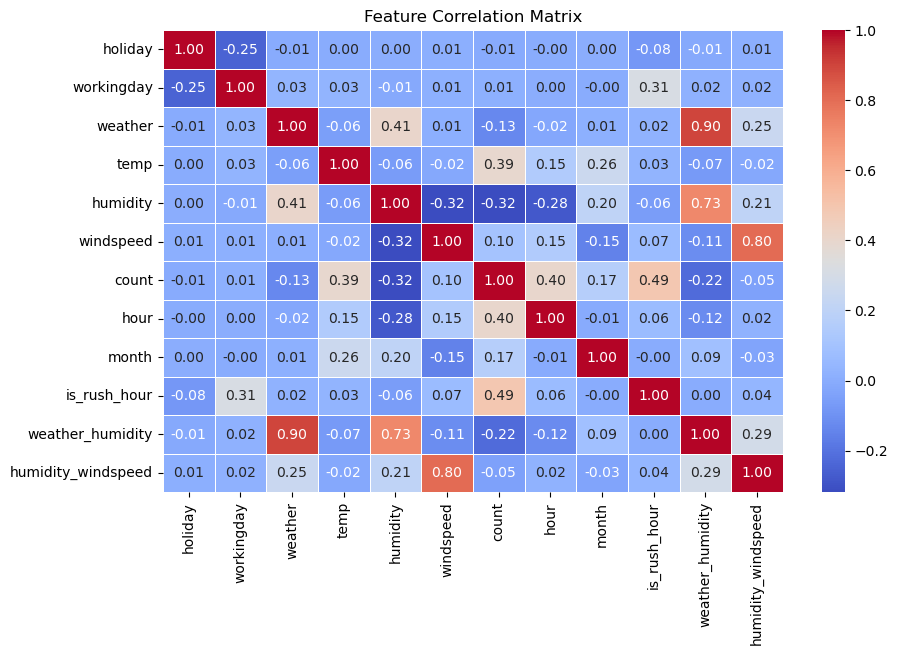

In [105]:
# Extract Numeric Features only
numeric_features = train_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

### Identify moderately correlated features:
- correlation between **0.3** and **0.7**

In [89]:
# Find feature pairs with moderate correlation
numeric_features = train_df.select_dtypes(include=['number'])
correlation_matrix = numeric_features.corr()

# Set a threshold for interesting interactions
threshold = 0.3

# Get feature pairs with correlation within the range
interaction_candidates = correlation_matrix[
    (abs(correlation_matrix) > threshold) & (abs(correlation_matrix) < 0.7)
]
print(interaction_candidates)

              holiday  workingday   weather      temp  humidity  windspeed  \
holiday           NaN         NaN       NaN       NaN       NaN        NaN   
workingday        NaN         NaN       NaN       NaN       NaN        NaN   
weather           NaN         NaN       NaN       NaN  0.406244        NaN   
temp              NaN         NaN       NaN       NaN       NaN        NaN   
humidity          NaN         NaN  0.406244       NaN       NaN  -0.318607   
windspeed         NaN         NaN       NaN       NaN -0.318607        NaN   
count             NaN         NaN       NaN  0.394454 -0.317371        NaN   
hour              NaN         NaN       NaN       NaN       NaN        NaN   
month             NaN         NaN       NaN       NaN       NaN        NaN   
is_rush_hour      NaN    0.311084       NaN       NaN       NaN        NaN   

                 count      hour  month  is_rush_hour  
holiday            NaN       NaN    NaN           NaN  
workingday         NaN       

While Avoiding data Leakage, the two candidate pairs for a new interaction feature are `weather` and `humidity` and `humidity` and `windspeed`.
- These new features are the `weather-humidity-index` and the `humidity-windspeed-index` and will be obtained by multiplying together the constituent features

In [90]:
# Create new interaction features
train_df["weather_humidity"] = train_df["weather"] * train_df["humidity"]
train_df["humidity_windspeed"] = train_df["humidity"] * train_df["windspeed"]

In [91]:
# View these new features
train_df.head()

,datetime,holiday,workingday,weather,temp,humidity,windspeed,count,hour,month,is_rush_hour,weather_humidity,humidity_windspeed
0,2011-01-01 00:00:00,0,0,1,9.84,81,0.0,16,0,1,0,81,0.0
1,2011-01-01 01:00:00,0,0,1,9.02,80,0.0,40,1,1,0,80,0.0
2,2011-01-01 02:00:00,0,0,1,9.02,80,0.0,32,2,1,0,80,0.0
3,2011-01-01 03:00:00,0,0,1,9.84,75,0.0,13,3,1,0,75,0.0
4,2011-01-01 04:00:00,0,0,1,9.84,75,0.0,1,4,1,0,75,0.0


In [92]:
# Apply these New features to the test data and save both datasets
test_df["weather_humidity"] = test_df["weather"] * test_df["humidity"]
test_df["humidity_windspeed"] = test_df["humidity"] * test_df["windspeed"]

# Save both Datasets
train_df.to_csv("data/train_additional_features.csv", index=False)
test_df.to_csv("data/test_additional_features.csv", index=False)

## Now Train an AutoGluon Model with these new features

In [93]:
predictor_new_interaction_features = TabularPredictor(label="count", 
                             eval_metric='rmse').fit(
    train_data=train_df,
    time_limit=600,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250317_211020"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Feb 11 11:40:46 UTC 2025
CPU Count:          2
Memory Avail:       1.21 GB / 3.76 GB (32.2%)
Disk Space Avail:   8589934583.12 GB / 8589934592.00 GB (100.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit

### Explore the Results

In [94]:
%%capture
# Get the fit summary (without extra text)
new_interaction_features_summary = predictor_new_interaction_features.fit_summary()

In [95]:
# Extract and print only the top 5 models with key columns
print(new_interaction_features_summary["leaderboard"][["model", "score_val", "fit_time", "pred_time_val"]].head(5))

                 model  score_val    fit_time  pred_time_val
0  WeightedEnsemble_L3 -30.874522  361.120610      23.320942
1      CatBoost_BAG_L2 -31.146665  306.012155      21.640848
2      LightGBM_BAG_L2 -31.516649  286.078829      21.827425
3    LightGBMXT_BAG_L2 -31.548039  291.407981      22.930566
4  WeightedEnsemble_L2 -32.664640  261.162543      21.468880


Text(0.5, 0.98, 'Leaderboard of Best Performing Models with Additional Interaction Features ')

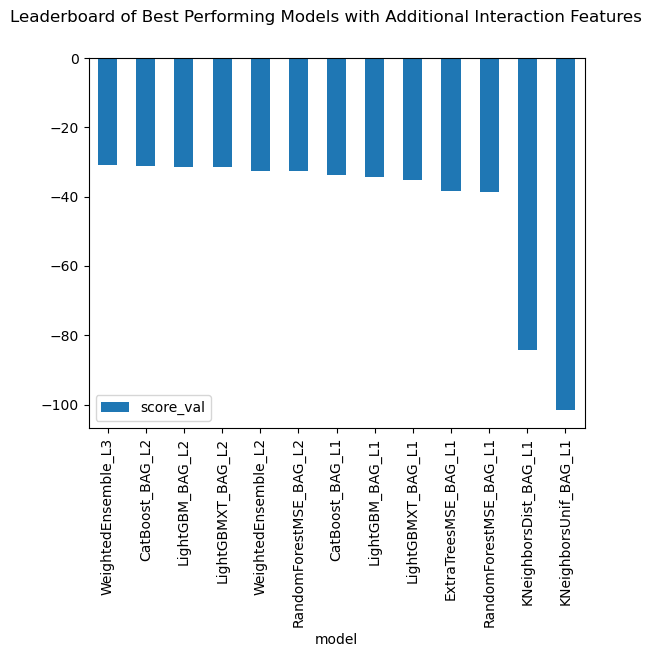

In [96]:
# Graphically view the best models
predictor_new_interaction_features.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')
plt.suptitle("Leaderboard of Best Performing Models with Additional Interaction Features ")

### Create Predictions from test df 

In [97]:
new_interaction_features_predictions = predictor_new_interaction_features.predict(test_df)
new_interaction_features_predictions.head()

0    16.718075
1    10.956985
2     9.439747
3     8.353729
4     7.036203
Name: count, dtype: float32

### Submit  Predictions to Kaggle

In [98]:
# Describe the predictions data
new_interaction_features_predictions.describe()

count    6493.000000
mean      160.909042
std       135.418304
min         1.196137
25%        54.642204
50%       127.688576
75%       234.056671
max       794.469727
Name: count, dtype: float64

In [99]:
# replace any negative values with '0'
new_interaction_features_predictions = new_interaction_features_predictions.clip(lower=0)

# Check no negative values exist
(new_interaction_features_predictions<0).sum()

0

In [100]:
# Initialise submissions df from submissions example
submission_new_interaction_features_df = submission_df

# populate count column with predictions
submission_new_interaction_features_df["count"] = new_interaction_features_predictions

# Convert to csv
submission_new_interaction_features_df.to_csv("new_interaction_features_submission.csv", index=False)

In [104]:
submission_new_features_df.head(15)

,datetime,count
0,2011-01-20 00:00:00,15.880080
1,2011-01-20 01:00:00,10.225492
2,2011-01-20 02:00:00,9.193098
3,2011-01-20 03:00:00,8.373124
4,2011-01-20 04:00:00,7.152901
5,2011-01-20 05:00:00,9.006608
6,2011-01-20 06:00:00,33.004112
7,2011-01-20 07:00:00,79.603951
8,2011-01-20 08:00:00,202.459183
9,2011-01-20 09:00:00,108.240005


In [102]:
!kaggle competitions submit -c bike-sharing-demand -f new_interaction_features_submission.csv -m "New Interaction Features Submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 723kB/s]
Successfully submitted to Bike Sharing Demand

In [103]:
# View the Score of Baseline Submission
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                                 date                        description                          status                     publicScore  privateScore  
---------------------------------------  --------------------------  -----------------------------------  -------------------------  -----------  ------------  
new_interaction_features_submission.csv  2025-03-17 21:26:19.613000  New Interaction Features Submission  SubmissionStatus.COMPLETE  0.66653      0.66653       
new_datetime_features_submission.csv     2025-03-17 21:01:17.063000  New Datetime Features Submission     SubmissionStatus.COMPLETE  0.61670      0.61670       
new_datetime_features_submission.csv     2025-03-17 20:26:50.437000  New Datetime Features Submission     SubmissionStatus.COMPLETE  0.61735      0.61735       
new_features_submission.csv              2025-03-17 19:56:51.243000  New Features Submission              SubmissionStatus.COMPLETE  0.63039      0.63039       


## Model Summary After Creating New Interaction Features
### The best model was the **WeightedEnsemble_L3** with an RMSE score of **30.874522** and a Kaggle score of **0.66653**.
- This is worse than before adding the interaction features hence we will examine the correlation matrix


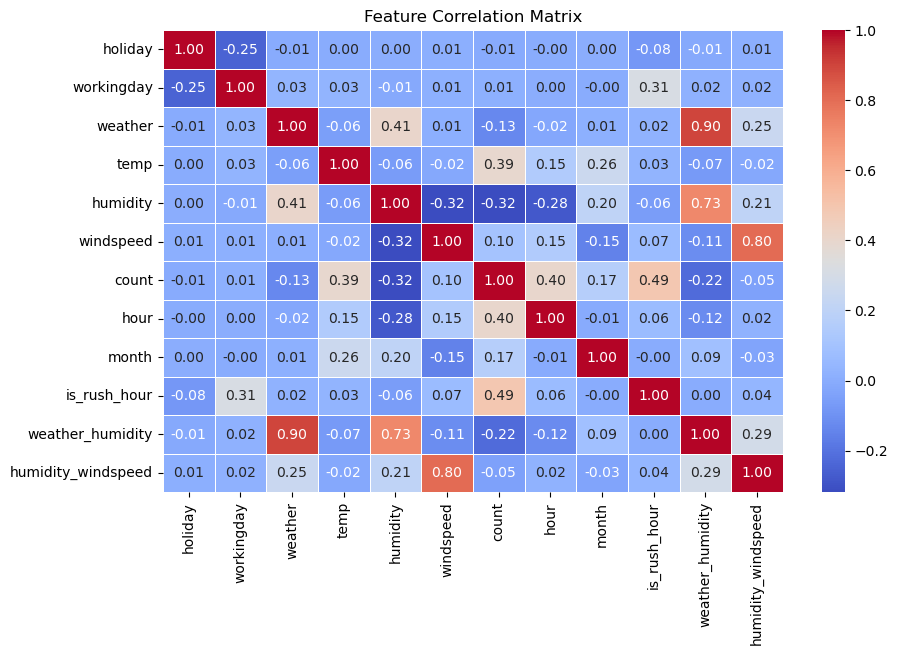

In [106]:
# Extract Numeric Features only
numeric_features = train_df.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


- these new features are introducing multicollinearity so will be removed, removing weather and humidity will result in loss of raw data so these new features will be removed instead

In [109]:
# drop interaction features
train_df.drop(columns=["weather_humidity", "humidity_windspeed"], inplace=True)
test_df.drop(columns=["weather_humidity", "humidity_windspeed"], inplace=True)

KeyError: "['weather_humidity', 'humidity_windspeed'] not found in axis"

In [111]:
train_df.head()

,datetime,holiday,workingday,weather,temp,humidity,windspeed,count,hour,month,is_rush_hour
0,2011-01-01 00:00:00,0,0,1,9.84,81,0.0,16,0,1,0
1,2011-01-01 01:00:00,0,0,1,9.02,80,0.0,40,1,1,0
2,2011-01-01 02:00:00,0,0,1,9.02,80,0.0,32,2,1,0
3,2011-01-01 03:00:00,0,0,1,9.84,75,0.0,13,3,1,0
4,2011-01-01 04:00:00,0,0,1,9.84,75,0.0,1,4,1,0


In [112]:
# Save the cleaned dataset as 'data_processed.csv'
train_df.to_csv("data/train_processed.csv", index=False)
test_df.to_csv("data/test_processed.csv", index=False)